# Eval runs

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import re

pd.set_option('display.max_columns', None)

In [16]:
def process_and_plot(file_path, ylim, front_rr1, full_concat_rr1, with_pos=True):
    # Read the file
    with open(file_path, 'r') as file:
        data = file.readlines()

    results = []

    experiment_pattern = re.compile(r'Perform 1:N Evaluation on (\S+)')
    rr1_pattern = re.compile(r'RR1: ([\d\.]+)')
    concat_rr1_pattern = re.compile(r'Concat-RR1: ([\d\.]+)')

    current_experiment = None

    for line in data:
        exp_match = experiment_pattern.search(line)
        rr1_match = rr1_pattern.search(line)
        concat_rr1_match = concat_rr1_pattern.search(line)
        
        if exp_match:
            current_experiment = exp_match.group(1)
        
        if rr1_match and concat_rr1_match:
            rr1 = float(rr1_match.group(1))
            concat_rr1 = float(concat_rr1_match.group(1))
            results.append((current_experiment[12:], rr1, concat_rr1))

    experiments = [r[0] for r in results]
    rr1_values = [r[1] for r in results]
    concat_rr1_values = [r[2] for r in results]

    if with_pos:
        # Extract x, y coordinates from experiment names
        x_coords = []
        y_coords = []
        for exp in experiments:
            y, x = map(int, exp.split('_'))
            x_coords.append(x)
            y_coords.append(y)

        fig, ax = plt.subplots(figsize=(8, 6))
        sc = ax.scatter(x_coords, y_coords, c=concat_rr1_values, cmap='viridis', edgecolor='black', s=100)
        plt.colorbar(sc, label='Concat-RR1 Accuracy')
        ax.set_xlabel('Azimuth')
        ax.set_ylabel('Altitude')
        ax.set_title('Accuracy Distribution Based on Position')
        for i, txt in enumerate(concat_rr1_values):
            ax.text(x_coords[i], y_coords[i]+1.5, f'{txt:.2f}%', fontsize=8, ha='center', va='center', color='black')
        plt.grid(True)
        plt.show()

    x = np.arange(len(experiments))
    width = 0.4

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x + width/2, concat_rr1_values, width, label='Concat-RR1', color='orange')
    ax.axhline(y=front_rr1, color='blue', linestyle='--', label='FRONT ONLY')
    ax.axhline(y=full_concat_rr1, color='green', linestyle='--', label='CONCAT 25 POSES')
    ax.set_ylabel('Scores')
    ax.set_title('')
    ax.set_xticks(x)
    ax.set_xticklabels(experiments, rotation=90)
    ax.set_ylim(ylim)
    ax.legend()

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['blue' if len(exp) > 11 else 'red' for exp in experiments]
    ax.scatter(rr1_values, concat_rr1_values, color=colors, label='RR1')
    ax.axhline(y=front_rr1, color='blue', linestyle='--', label='FRONT ONLY')
    ax.axhline(y=full_concat_rr1, color='green', linestyle='--', label='CONCAT 25 POSES')

    for i, txt in enumerate(experiments):
        ax.annotate(txt, (rr1_values[i], concat_rr1_values[i]), fontsize=8, ha='right')

    ax.set_xlabel('RR1')
    ax.set_ylabel('Concat-RR1')
    ax.set_title('')
    ax.legend()

    plt.grid(True)
    plt.show()

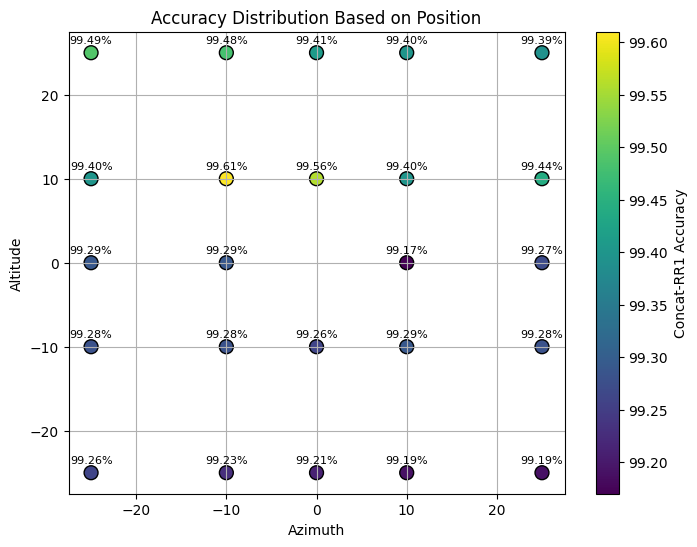

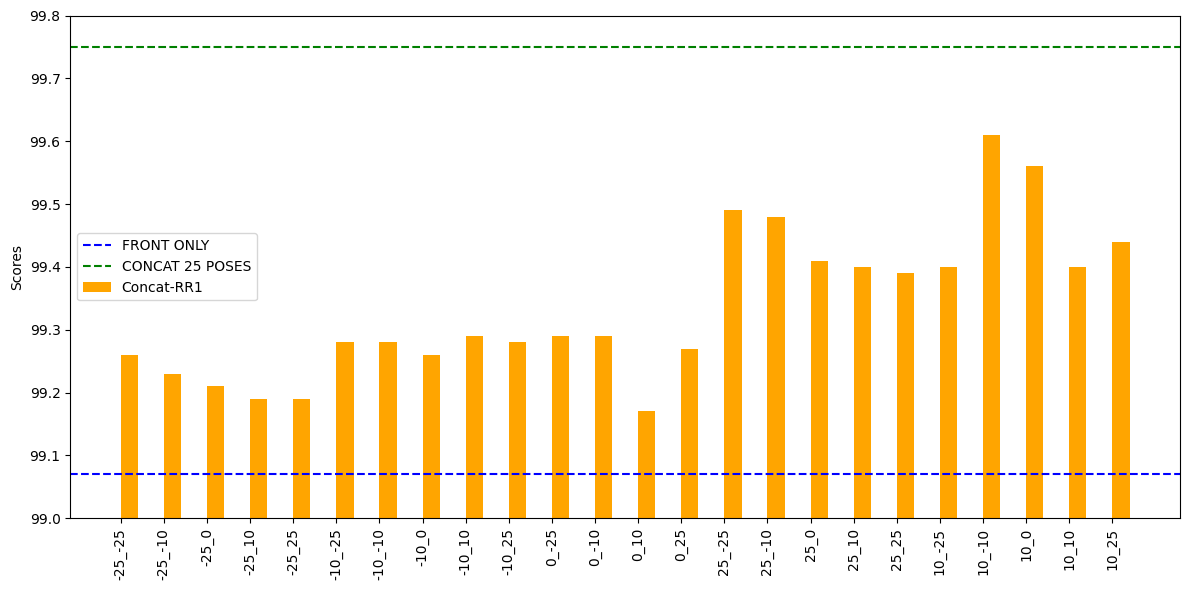

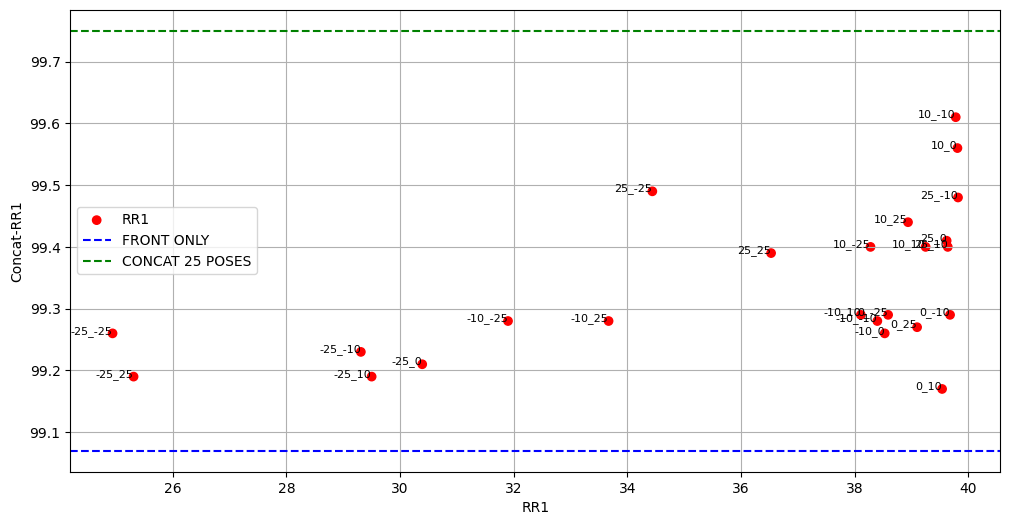

In [17]:
process_and_plot('F:\\Face\\HM_IDENT_3DFR\\src\\notebooks\\perspectives_ms1m.txt', ylim=(99, 99.8), front_rr1=99.07, full_concat_rr1=99.75)

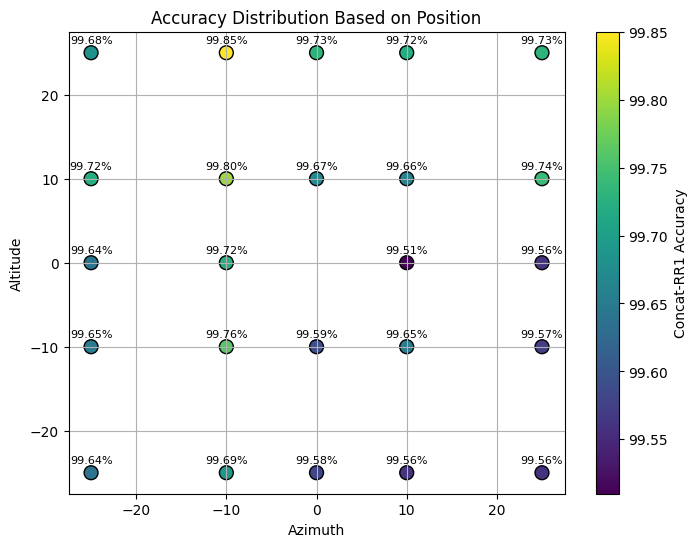

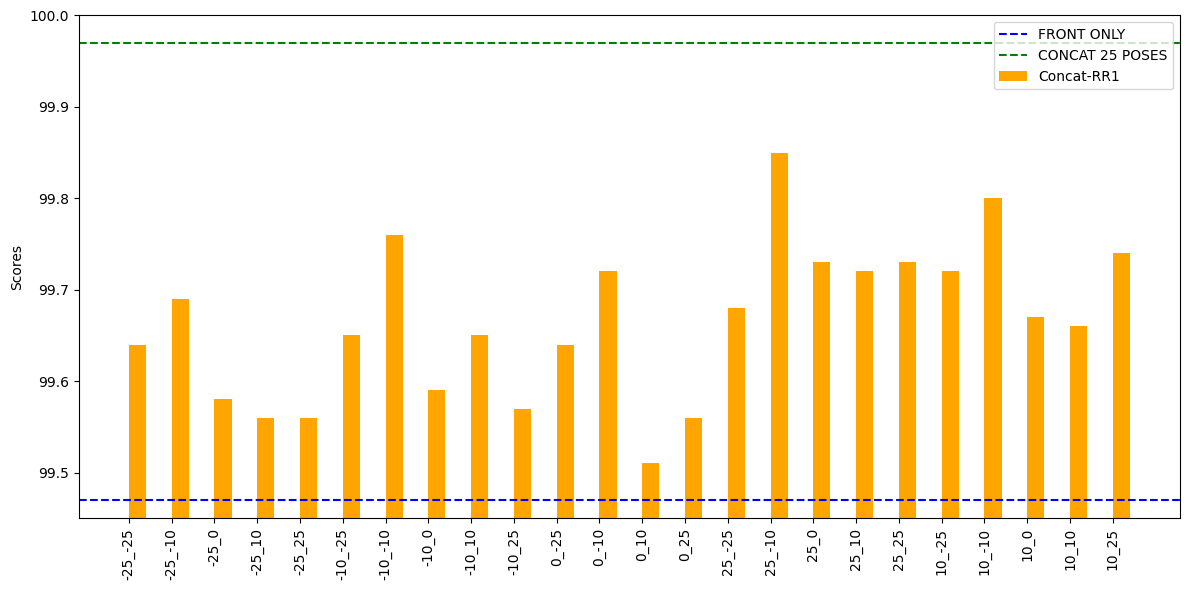

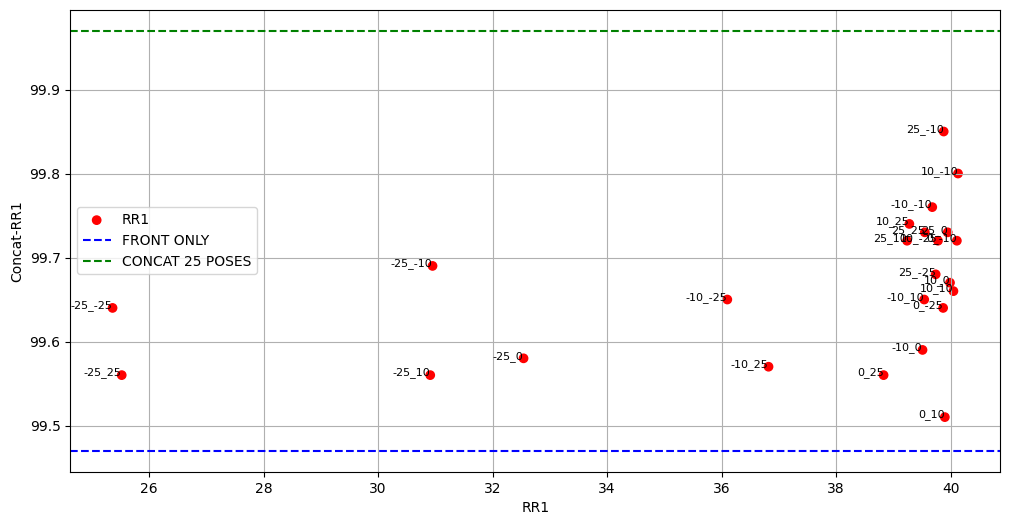

In [18]:
process_and_plot('F:\\Face\\HM_IDENT_3DFR\\src\\notebooks\\perspectives_asia.txt', ylim=(99.45, 100), front_rr1=99.47, full_concat_rr1=99.97)

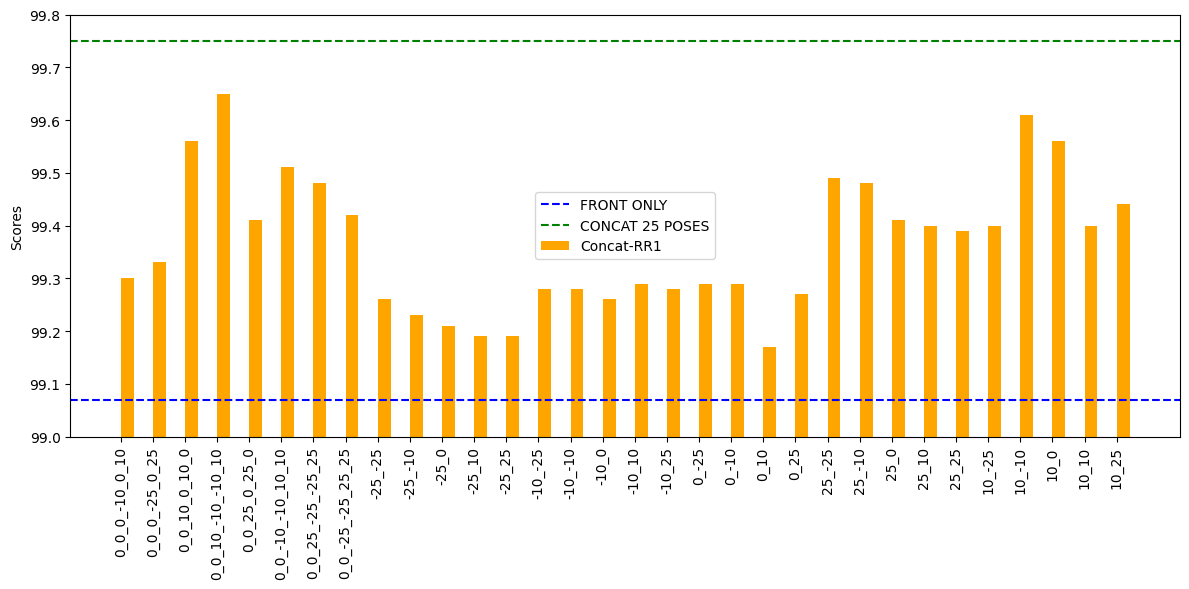

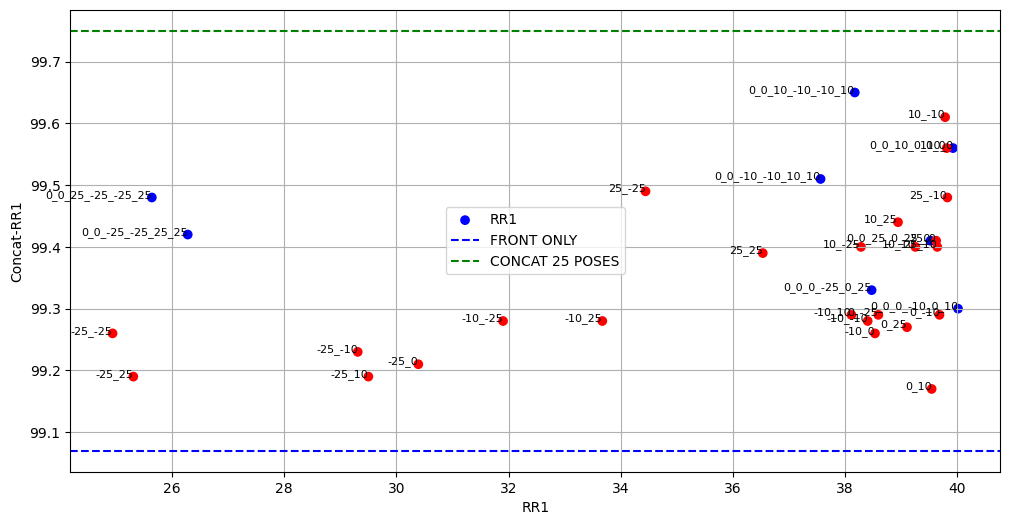

In [19]:
process_and_plot('F:\\Face\\HM_IDENT_3DFR\\src\\notebooks\\perspectives_ms1m_3.txt', ylim=(99, 99.8), front_rr1=99.07, full_concat_rr1=99.75, with_pos=False)

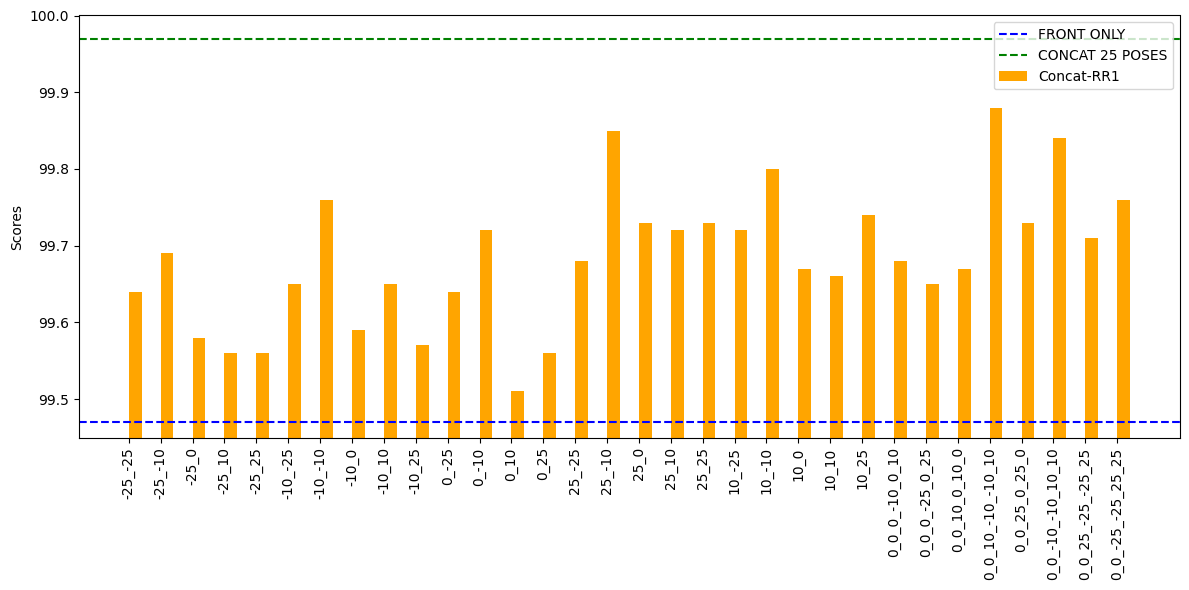

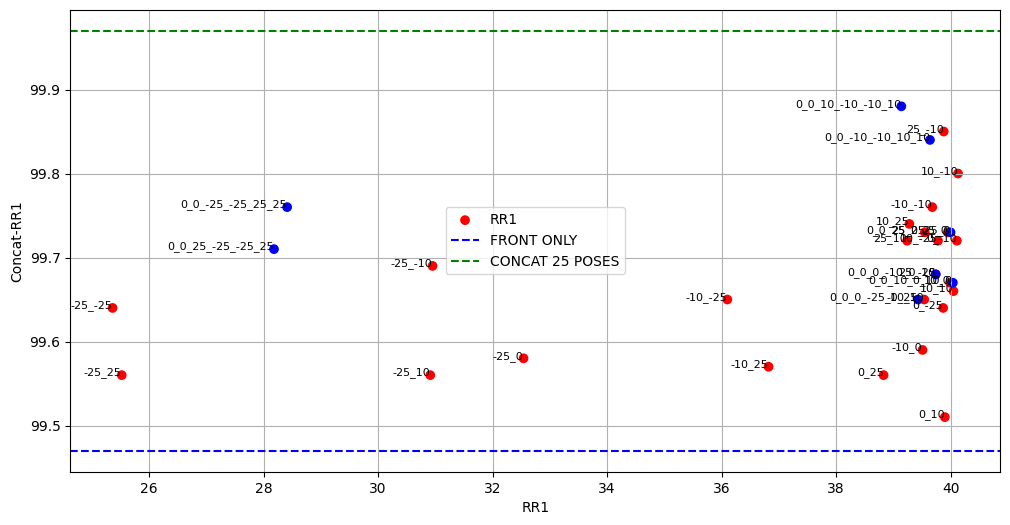

In [20]:
process_and_plot('F:\\Face\\HM_IDENT_3DFR\\src\\notebooks\\perspectives_asia_3.txt', ylim=(99.45, 100), front_rr1=99.47, full_concat_rr1=99.97, with_pos=False)

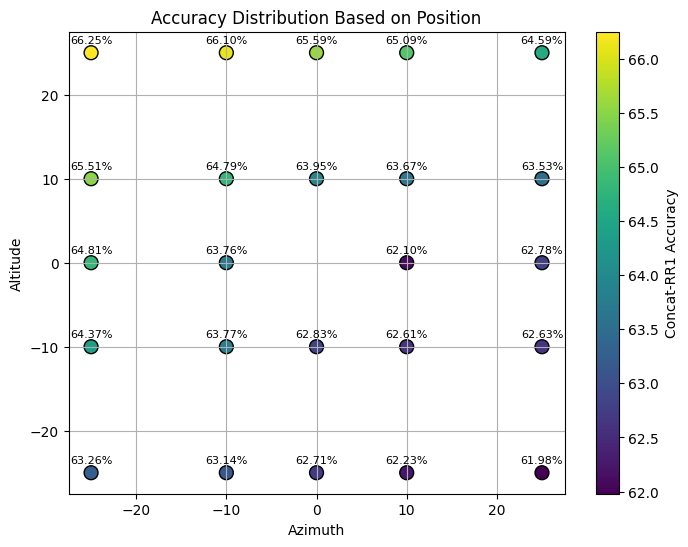

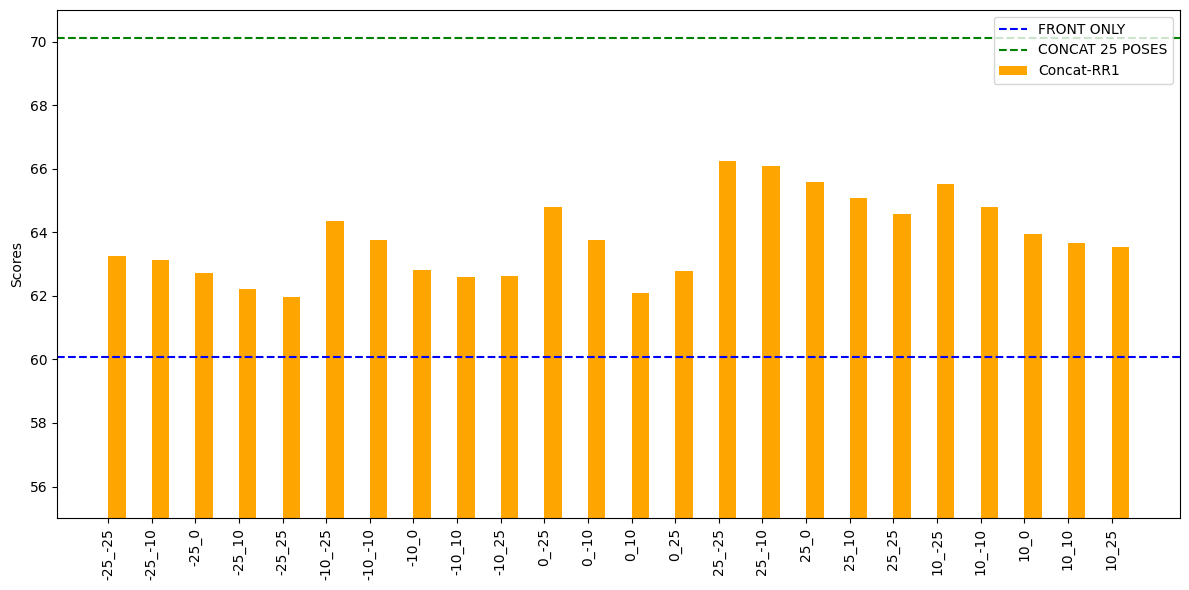

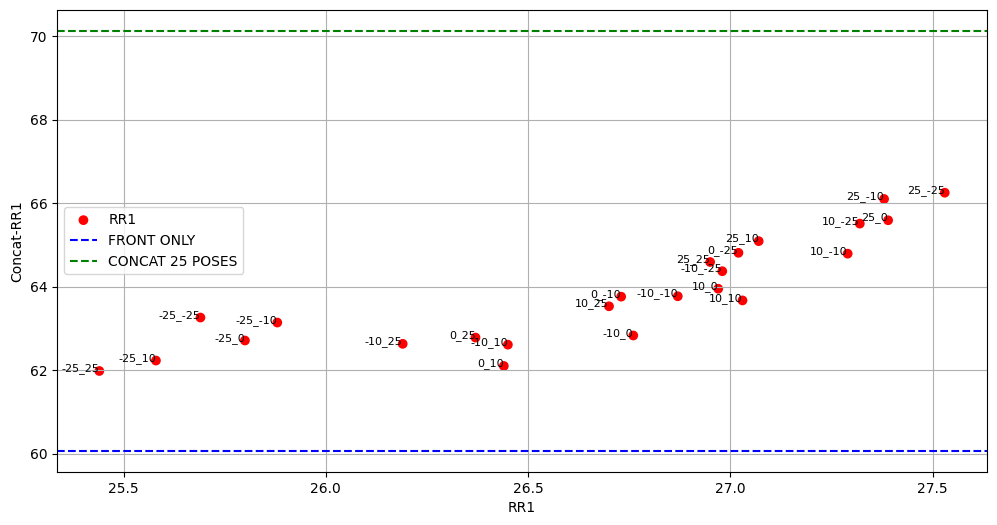

In [26]:
process_and_plot('F:\\Face\\HM_IDENT_3DFR\\src\\notebooks\\perspectives_ms1m_vox2train.txt', ylim=(55, 71), front_rr1=60.07, full_concat_rr1=70.13)

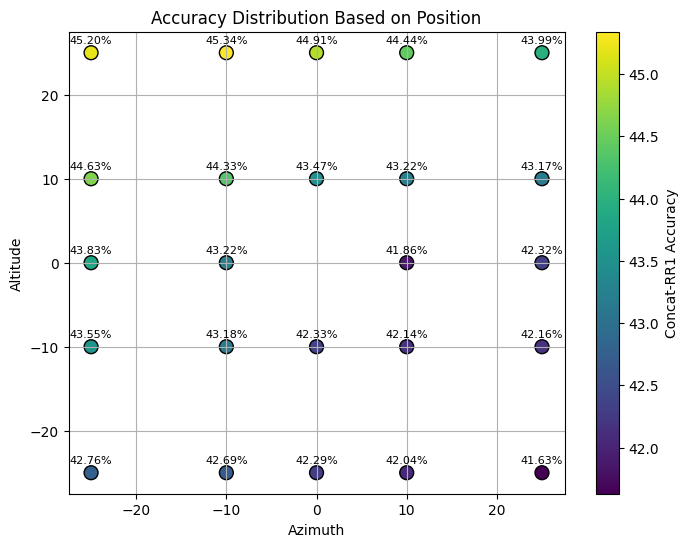

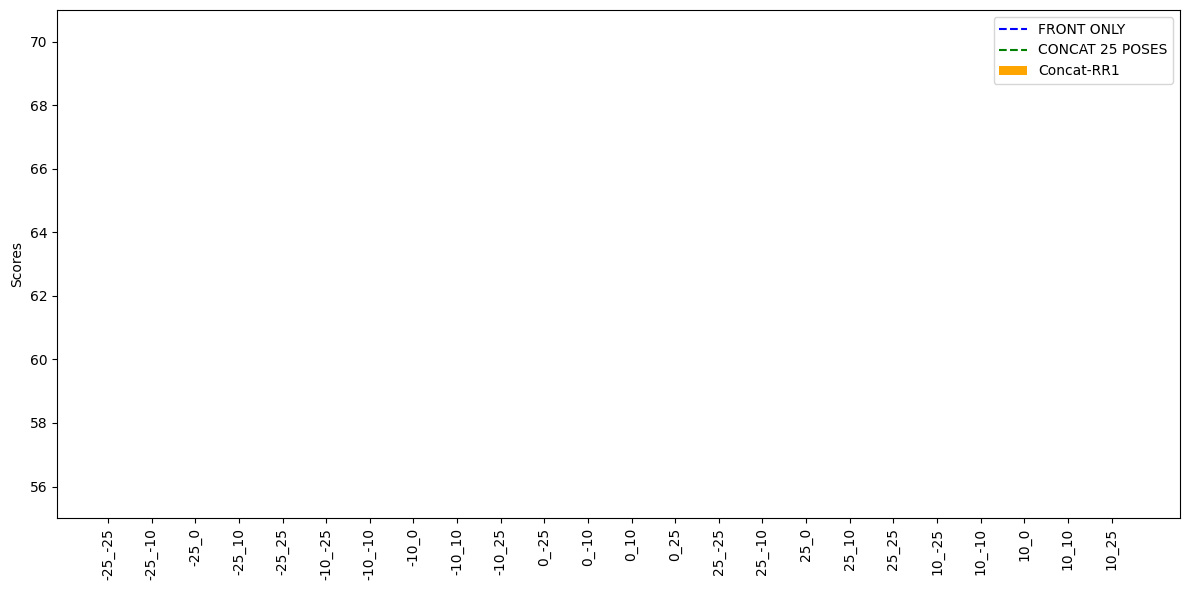

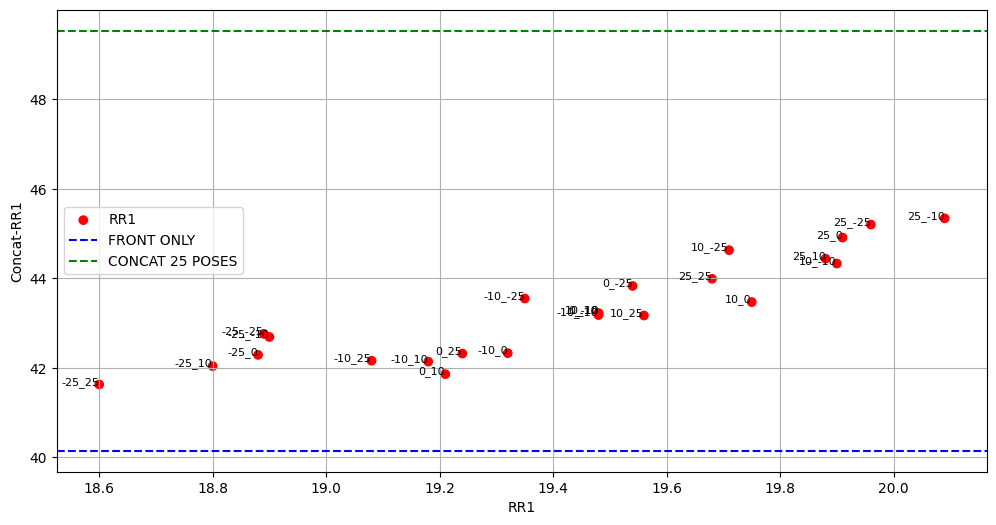

In [27]:
process_and_plot('F:\\Face\\HM_IDENT_3DFR\\src\\notebooks\\perspectives_asia_vox2train.txt', ylim=(55, 71), front_rr1=40.15, full_concat_rr1=49.53)